In [9]:
import import_ipynb
from DQN.SimpleDQNLazyFrames import Agent
import gym
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import losses
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import logging
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 84, 84, 4)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 16)        4112      
                                                                 
 conv2d_7 (Conv2D)           (None, 9, 9, 32)          8224      
                                                                 
 flatten_3 (Flatten)         (None, 2592)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               663808    
                                                                 
 dense_9 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 677,172
Trainable params: 677,172
Non-trainab

0.0
[121.06482     7.1914396  13.025     -33.516365 ]
[120.98739     7.1842465  13.005138  -33.49471  ]
tf.Tensor([121.77752   0.        0.        0.     ], shape=(4,), dtype=float32)
tf.Tensor([121.77752     7.1914396  13.025     -33.516365 ], shape=(4,), dtype=float32)
+++++++++++
False
False
False
False
0.0
[131.58        7.7132244  14.063673  -36.304886 ]
[131.51617     7.7131324  14.05631   -36.287395 ]
tf.Tensor([133.20102   0.        0.        0.     ], shape=(4,), dtype=float32)
tf.Tensor([133.20102     7.7132244  14.063673  -36.304886 ], shape=(4,), dtype=float32)
+++++++++++
False
False
False
False
0.0
[150.52177    8.604542  15.96163  -41.483253]
[150.55984    8.608925  15.978815 -41.489357]
tf.Tensor([149.05424   0.        0.        0.     ], shape=(4,), dtype=float32)
tf.Tensor([149.05424    8.604542  15.96163  -41.483253], shape=(4,), dtype=float32)
+++++++++++
False
False
Episode:          6
Score:          0.0
Epsilon: 0.999303225806452
__________
False
False
False
Fals

False
False
False
False
False
False
False
False
False
0.0
[140.89807   22.529753  15.902967 -35.340153]
[140.92116   22.527437  15.906085 -35.344883]
tf.Tensor([142.51195   0.        0.        0.     ], shape=(4,), dtype=float32)
tf.Tensor([142.51195   22.529753  15.902967 -35.340153], shape=(4,), dtype=float32)
+++++++++++
False
False
False
False
0.0
[126.22214   22.252121  14.336608 -31.220873]
[126.08821   22.223421  14.335297 -31.178902]
tf.Tensor([124.82733   0.        0.        0.     ], shape=(4,), dtype=float32)
tf.Tensor([124.82733   22.252121  14.336608 -31.220873], shape=(4,), dtype=float32)
+++++++++++
False
False
False
False
0.0
[121.49635   22.910318  13.812904 -29.929762]
[121.42762   22.89419   13.810043 -29.913284]
tf.Tensor([121.21335   0.        0.        0.     ], shape=(4,), dtype=float32)
tf.Tensor([121.21335   22.910318  13.812904 -29.929762], shape=(4,), dtype=float32)
+++++++++++
False
False
False
False
0.0
[123.61883   24.478764  14.047961 -30.442099]
[123.637

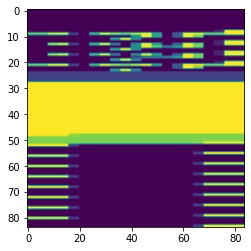

In [10]:
#agent and environment optimized for Atari games
#https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

class AtariGame:
    def __init__(self, env_name, render_mode=None, name=None):
        self.name = name
        self.sample_batch_size = 32
        self.episodes          = 5e6
        self.env_name          = env_name
        self.env               = wrap_deepmind(env = make_atari(self.env_name), frame_stack=True, scale=True)
        self.frame_skip        = 4 #skip every 4th frame
        #84x84 greyscale
        self.reduzed_size      = (84, 84, self.frame_skip) #, greyscale(1), 84x84, 4 Pictures, 
        self.state_size        = self.reduzed_size
        self.action_size       = self.env.action_space.n
        self.termination_index = 10000
        self.history           = []
        self.save_freq         = 10000
        self.agent             = Agent(self.state_size, self.action_size, 
                                       #Parameters taken from Deepmind Breakout AI
                                       #input model layers as keras.layers objects
                                       anatomy=[layers.Conv2D(16,8,strides=4,activation=activations.relu),
                                                layers.Conv2D(32,4,strides=2,activation=activations.relu),
                                                layers.Conv2D(64,3,strides=2,activation=activations.relu),
                                                layers.Flatten(),
                                                layers.Dense(256, activation=activations.relu)],
                                       name=f"TEST-{self.env_name}-DQN",
                                       linear_decrease=True,
                                       epsilon=1,
                                       epsilon_decay=0.9/31000,
                                       epsilon_min=0.1,
                                       model_verbose=0,
                                       lr = 0.0025,
                                       gamma= 0.99,
                                       loss = losses.Huber(),
                                       max_memory_size=1e5
                                       )
        #print(self.state_size, self.action_size)
    
    def run(self, load_model = False, skip_training=False, overwrite_epsilon=-1, save=True, logs=False, log_freq=1):
        #LOGS ARE ALWAYS ENABLED
        logging.basicConfig(filename=f"models/{self.agent.default_name}.log",
                level=logging.INFO,
                format='%(levelname)s: %(asctime)s %(message)s',
                datefmt='%d/%m/%Y %I:%M:%S')
        
        #if true, try to load existing model
        if load_model:
            self.agent.load_model(overwrite_epsilon=overwrite_epsilon)
        try:
            training_batches = 0
            for index_episode in range(int(self.episodes)):
                state = self.env.reset() #returns a LazyFrame
                state_tensor = tf.expand_dims(np.array(state), 0)
                done = False
                score = 0 
                q = 0
                q_n = 0
                
                for index in range(0, self.termination_index):
                    if index > self.frame_skip:
                        action = self.agent.pick_action(state_tensor) 
                    else:
                        action = np.random.choice(self.agent.action_size)
                     
                    next_state, reward, done, _ = self.env.step(action)
                    
                    next_state_tensor = tf.expand_dims(np.array(next_state), 0)     
                    score += reward
                    #print(next_state.numpy().shape)
                    #store Lazyframes
                    self.agent.update_memory((state, action, reward, 
                                                      next_state, done))
                    
                    if (index % self.frame_skip == 0) and not skip_training:
                        if index > self.frame_skip:
                            q += np.amax(self.agent.predict(state_tensor))
                            q_n += 1
                            #dont use gpu memory when storing steps

                            training_batches += 1
                            self.agent.replay()  
                            
                    state = next_state
                    state_tensor = next_state_tensor
                    
                    if done:
                        break
                self.history.append(score)
                if len(self.history) > 100:
                    del self.history[:1]
                
                print(f"Episode: {index_episode:-10}")
                print(f"Score: {score:-12}")
                print(f"Epsilon: {self.agent.exploration_rate}")
                print("".join(["_" for i in range(10)]))
                if logs and index_episode % log_freq == 0:
                    running_reward = sum(self.history) / len(self.history)
                    logging.info(f"EPISODE: {index_episode}")
                    logging.info(f"AVG LAST {len(self.history)} REWARDS: {running_reward:0.2f}")
                    logging.info(f"BATCHES TRAINED: {training_batches}")
                    if q_n != 0:
                        logging.info(f"AVG Q VALUE: {(q / q_n):.5f}")
                    logging.info(f"SCORE: {score}")
                    logging.info(f"DURATION (STEPS): {index}")
                    logging.info(f"EPSILON: {self.agent.exploration_rate:.5f}")
                    logging.info(f"MEMORY SIZE: {len(self.agent.state_hist)}")
                    logging.info("".join(["-" for i in range(12)]))
                
                if index_episode % self.save_freq == 0 and save and index_episode != 0:
                    self.agent.save_model(name="EP"+str(index_episode/1000)+"k", save_memory=False)
                
        except:
            if save:
                self.agent.save_model(name="ERROR", save_memory=False)
            logging.info("".join(["+" for i in range(14)]))
            logging.exception("An error has occured")
            logging.info("".join(["+" for i in range(14)]))
            
        finally:
            #save model upon interrupting
            if logs or save:
                logging.info(f"TRAINING FINISHED AFTER {training_batches} BATCHES")
                logging.info("".join(["+" for i in range(14)]))
                if save:
                    model_name = self.agent.build_name(name="FINISHED")
                    logging.info(f"MODEL NAME: {model_name}")
                logging.info("".join(["+" for i in range(14)]))
            #print(training_batches)
            if save:
                self.agent.save_model(name="FINISHED", save_memory=True)

if __name__ == "__main__":
    #render modes: "human", None
    atari = AtariGame("BreakoutNoFrameskip-v4", render_mode="human")
    atari.run(load_model=False, skip_training=False, overwrite_epsilon=0, save=False, logs=True, log_freq=100)


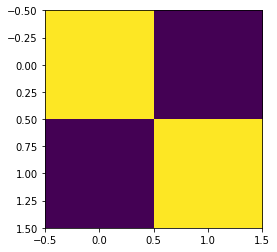

In [4]:
plt.imshow([[1, 0], [0, 1]])